In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load all relevant files
train = pd.read_csv('../data/train.csv')
stores = pd.read_csv('../data/stores.csv')
oil = pd.read_csv('../data/oil.csv')
holidays = pd.read_csv('../data/holidays_events.csv')
transactions = pd.read_csv('../data/transactions.csv')

# Quick overview
print("Train shape:", train.shape)
print("Stores shape:", stores.shape)
print("Oil shape:", oil.shape)
print("Holidays shape:", holidays.shape)
print("Transactions shape:", transactions.shape)

Train shape: (3000888, 6)
Stores shape: (54, 5)
Oil shape: (1218, 2)
Holidays shape: (350, 6)
Transactions shape: (83488, 3)


In [2]:
print("=== TRAIN ===")
print(train.head())
print("\n=== STORES ===")
print(stores.head())
print("\n=== OIL ===")
print(oil.head())
print("\n=== HOLIDAYS ===")
print(holidays.head())

=== TRAIN ===
   id        date  store_nbr      family  sales  onpromotion
0   0  2013-01-01          1  AUTOMOTIVE    0.0            0
1   1  2013-01-01          1   BABY CARE    0.0            0
2   2  2013-01-01          1      BEAUTY    0.0            0
3   3  2013-01-01          1   BEVERAGES    0.0            0
4   4  2013-01-01          1       BOOKS    0.0            0

=== STORES ===
   store_nbr           city                           state type  cluster
0          1          Quito                       Pichincha    D       13
1          2          Quito                       Pichincha    D       13
2          3          Quito                       Pichincha    D        8
3          4          Quito                       Pichincha    D        9
4          5  Santo Domingo  Santo Domingo de los Tsachilas    D        4

=== OIL ===
         date  dcoilwtico
0  2013-01-01         NaN
1  2013-01-02       93.14
2  2013-01-03       92.97
3  2013-01-04       93.12
4  2013-01-07    

# 1. Target Variable Overview

In [3]:
print(train['sales'].describe())
print(f"\nZero sales rows: {(train['sales'] == 0).sum()} ({(train['sales'] == 0).mean()*100:.1f}%)")
print(f"Negative sales: {(train['sales'] < 0).sum()}")

count    3.000888e+06
mean     3.577757e+02
std      1.101998e+03
min      0.000000e+00
25%      0.000000e+00
50%      1.100000e+01
75%      1.958473e+02
max      1.247170e+05
Name: sales, dtype: float64

Zero sales rows: 939130 (31.3%)
Negative sales: 0


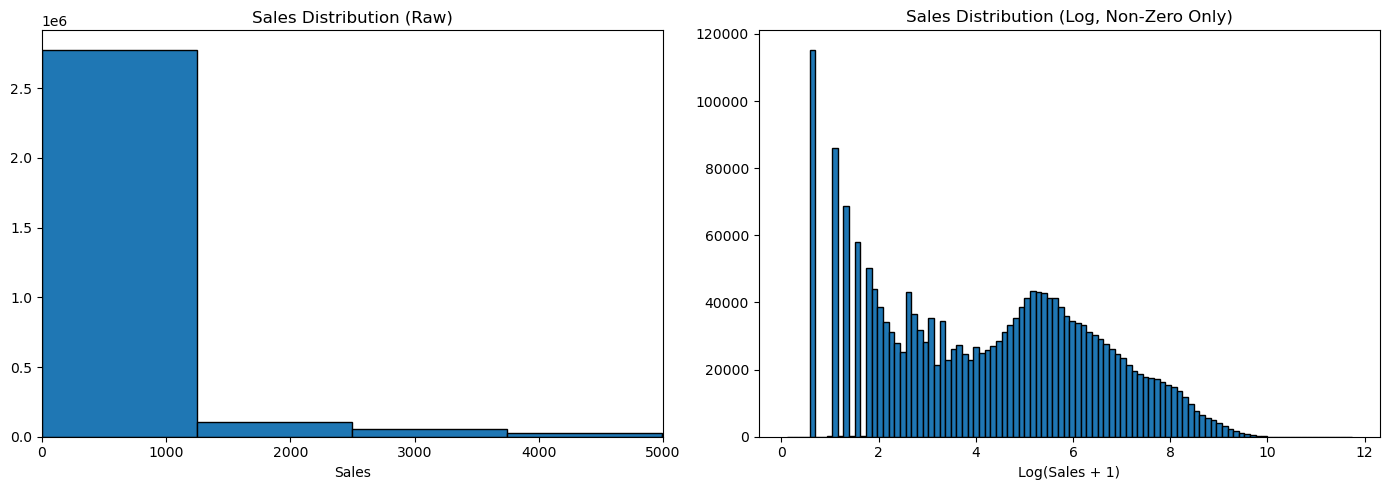

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Raw distribution (capped for visibility)
axes[0].hist(train['sales'], bins=100, edgecolor='black')
axes[0].set_title('Sales Distribution (Raw)')
axes[0].set_xlabel('Sales')
axes[0].set_xlim(0, 5000)  # Cap for visibility

# Log distribution (excluding zeros)
non_zero_sales = train[train['sales'] > 0]['sales']
axes[1].hist(np.log1p(non_zero_sales), bins=100, edgecolor='black')
axes[1].set_title('Sales Distribution (Log, Non-Zero Only)')
axes[1].set_xlabel('Log(Sales + 1)')

plt.tight_layout()
plt.show()

# 2. Time Range & Granularity

In [5]:
train['date'] = pd.to_datetime(train['date'])

print(f"Date range: {train['date'].min()} to {train['date'].max()}")
print(f"Total days: {train['date'].nunique()}")
print(f"Expected days (no gaps): {(train['date'].max() - train['date'].min()).days + 1}")
print(f"\nUnique stores: {train['store_nbr'].nunique()}")
print(f"Unique product families: {train['family'].nunique()}")
print(f"\nRows check: {train['date'].nunique()} days × {train['store_nbr'].nunique()} stores × {train['family'].nunique()} families = {train['date'].nunique() * train['store_nbr'].nunique() * train['family'].nunique()}")

Date range: 2013-01-01 00:00:00 to 2017-08-15 00:00:00
Total days: 1684
Expected days (no gaps): 1688

Unique stores: 54
Unique product families: 33

Rows check: 1684 days × 54 stores × 33 families = 3000888


In [6]:
full_range = pd.date_range(start=train['date'].min(), end=train['date'].max(), freq='D')
actual_dates = train['date'].unique()
missing_dates = full_range.difference(actual_dates)
print(f"Missing dates: {missing_dates.tolist()}")

Missing dates: [Timestamp('2013-12-25 00:00:00'), Timestamp('2014-12-25 00:00:00'), Timestamp('2015-12-25 00:00:00'), Timestamp('2016-12-25 00:00:00')]


"Data spans 2013-01-01 to 2017-08-15 (~4.5 years). Daily granularity. 4 missing dates all Dec 25 (Christmas closures). 54 stores × 33 product families = 1,782 time series to potentially model."

# 3. Aggregate Time Series Plot